## Import Dask and modules needed

In [1]:
# Import Dask so it can ruster

from dask.distributed import Client, progress
client = Client(dashboard_address=':5555')  # set up local cluster on laptop
client

# Import modules
import xarray as xr
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress, t

## Read in the AR Catalog

In [2]:

# Load AR catalog data
ar_data = pd.read_csv(r'C:\Users\brand\Documents\School Files\Illinois Courses\ATMS 596\Data\ARcatalog_NCEP_NEW_1948-2018_Comprehensive_FINAL_29JAN18.csv')

# Drop unnecessary columns and convert to xarray
ar_data['Date'] = pd.to_datetime(ar_data[['Year', 'Month']].astype(str).agg('-'.join, axis=1))
ar_data = ar_data.drop(columns=['Day', 'Hour'])
ar_catalog = xr.Dataset(
    {
        'Coastal_latitude': (['time'], ar_data['Coastal latitude of the landfalling AR (at AR center)'].values),
        'Coastal_longitude': (['time'], ar_data['Coastal longitude of the landfalling AR'].values),
        'IVT': (['time'], ar_data['IVT at landfall grid point'].values),
        'IWTv': (['time'], ar_data['IWTv at landfall grid point'].values),
        'UVTu': (['time'], ar_data['UVTu at landfall grid point'].values),
        'IWV': (['time'], ar_data['IWV'].values),
        'U_component': (['time'], ar_data['U component of wind over the landfall grid point'].values),
        'V_component': (['time'], ar_data['V component of wind over the landfall grid point'].values),
    },
    coords={
        'time': ar_data['Date'].values,
        'AR_ID': ar_data['AR ID'].values
    }
)

# Convert the time coordinate to a Pandas DatetimeIndex
ar_catalog['time'] = pd.to_datetime(ar_catalog['time'].values)


In [3]:
ar_catalog

<xarray.Dataset>
Dimensions:            (time: 35154, AR_ID: 35154)
Coordinates:
  * time               (time) datetime64[ns] 1948-01-01 ... 2018-01-01
  * AR_ID              (AR_ID) int64 1 1 1 1 1 1 ... 4247 4247 4247 4247 4247
Data variables:
    Coastal_latitude   (time) float64 45.0 45.0 40.0 40.0 ... 42.5 40.0 40.0
    Coastal_longitude  (time) float64 237.5 237.5 237.5 ... 237.5 237.5 237.5
    IVT                (time) float64 304.0 391.8 275.6 ... 501.5 383.4 331.9
    IWTv               (time) float64 196.8 173.1 121.9 ... 386.3 297.1 188.5
    UVTu               (time) float64 231.7 351.5 247.2 ... 319.7 242.3 273.2
    IWV                (time) float64 18.5 19.9 17.3 17.4 ... 16.7 16.2 15.3
    U_component        (time) float64 9.7 14.1 9.1 10.7 ... 7.8 9.4 5.3 10.2
    V_component        (time) float64 13.8 10.1 8.6 5.5 ... 13.0 11.4 8.4 5.2

## Map showing area of interest and latitude bands

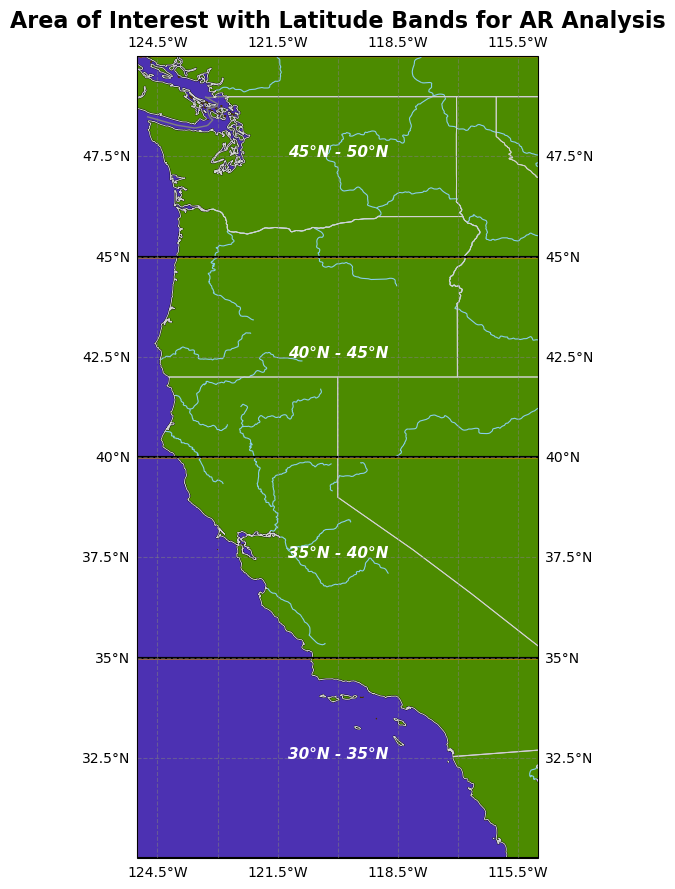

In [4]:


# Define the area of interest (e.g., U.S. West Coast)
min_lon, max_lon = -125, -115  # Longitude range (West Coast of the U.S.)
min_lat, max_lat = 30, 50  # Latitude range 

# Create a map with Cartopy
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Set up the extent of the map
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Add higher resolution natural features to the map (e.g., land, oceans, rivers)
ax.add_feature(cfeature.LAND, facecolor='green', edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='blue', edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1.2)
ax.add_feature(cfeature.RIVERS, edgecolor='skyblue', linewidth=0.8)

# Add state boundaries with thinner lines
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='gray')
ax.add_feature(cfeature.STATES, edgecolor='lightgray', linewidth=0.7)

# Add gridlines with a subtle style
ax.gridlines(draw_labels=True, color='gray', linestyle='--', alpha=0.5)

# Latitude Bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]

# Plot latitude bands (shaded areas)
for band in latitude_bands:
    ax.fill_betweenx(
        [band[0], band[1]], min_lon, max_lon, color='orange', alpha=0.3
    )
    # Add black lines to divide the latitude bands
    ax.plot([min_lon, max_lon], [band[0], band[0]], color='black', lw=1.5)  # Top line
    ax.plot([min_lon, max_lon], [band[1], band[1]], color='black', lw=1.5)  # Bottom line

# Add labels to the latitude bands with white font
for band in latitude_bands:
    ax.text(
        -120, (band[0] + band[1]) / 2, f"{band[0]}°N - {band[1]}°N", 
        fontsize=11, ha='center', color='white', fontweight='bold', 
        style='italic'
    )

# Add a title to the map
ax.set_title("Area of Interest with Latitude Bands for AR Analysis", fontsize=16, fontweight='bold')

# Adjust layout to prevent overlap and make the map more spacious
plt.tight_layout()

# Show the plot
plt.show()


# Analyze IVT, latitude, and wind components of observed AR's from 1950 to present

### AR Counts over time

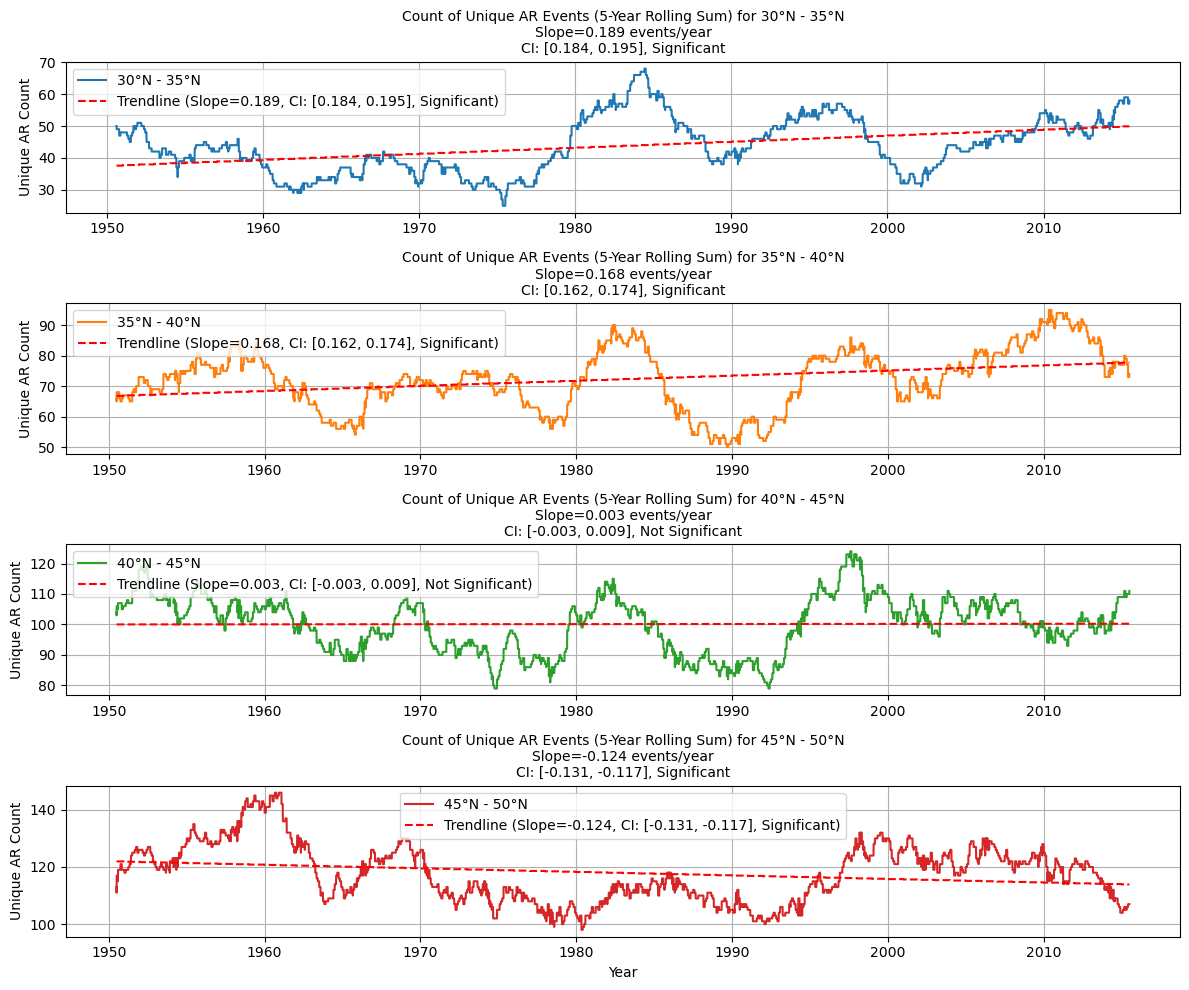

In [ ]:


# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
latitude = ar_catalog['Coastal_latitude'].values
ar_id = ar_catalog['AR_ID'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]
band_data = []

# Group data into latitude bands and calculate rolling unique AR_ID counts
for band in latitude_bands:
    # Mask for the current latitude band
    mask = (latitude >= band[0]) & (latitude < band[1])
    
    # Extract data for the latitude band
    band_time = time[mask]
    band_ar_id = ar_id[mask]
    
    # Create a DataFrame for grouping by day
    band_df = pd.DataFrame({'time': band_time, 'AR_ID': band_ar_id}).drop_duplicates()
    band_df.set_index('time', inplace=True)
    
    # Resample to daily frequency and count unique AR_IDs
    daily_unique_counts = band_df.resample('D').AR_ID.nunique()
    
    # Calculate the rolling sum of unique counts
    rolling_unique_counts = daily_unique_counts.rolling(window=window_size, center=True).sum()
    
    # Store data for plotting
    band_data.append((band, rolling_unique_counts.index, rolling_unique_counts.values))

# Plot the unique count of ARs for each latitude band with trendlines
plt.figure(figsize=(12, 10))

for i, (band, band_time, band_count) in enumerate(band_data):
    # Remove NaN values for regression
    valid_idx = ~pd.isnull(band_count)
    band_time_numeric = pd.to_datetime(band_time[valid_idx]).year  # Convert time to numeric for regression
    band_count_valid = band_count[valid_idx]
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(band_time_numeric, band_count_valid)
    
    # Calculate the 95% Confidence Interval for the slope
    n = len(band_count_valid)  # number of valid points
    t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
    margin_of_error = t_critical * std_err  # Margin of error for the slope
    ci_lower = slope - margin_of_error
    ci_upper = slope + margin_of_error
    significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
    
    # Plot the rolling count
    plt.subplot(len(latitude_bands), 1, i + 1)
    plt.plot(band_time, band_count, label=f"{band[0]}°N - {band[1]}°N", color=f"C{i}")
    
    # Plot the trendline
    trendline = slope * band_time_numeric + intercept
    plt.plot(band_time[valid_idx], trendline, color='red', linestyle='--', label=f'Trendline (Slope={slope:.3f}, CI: [{ci_lower:.3f}, {ci_upper:.3f}], {"Significant" if significant else "Not Significant"})')
    
    # Add title with slope value and CI info
    plt.title(f"Count of Unique AR Events (5-Year Rolling Sum) for {band[0]}°N - {band[1]}°N\nSlope={slope:.3f} events/year\nCI: [{ci_lower:.3f}, {ci_upper:.3f}], {'Significant' if significant else 'Not Significant'}", fontsize=10)
    plt.ylabel("Unique AR Count")
    plt.grid()
    plt.legend()

plt.xlabel("Year")
plt.tight_layout()
plt.show()


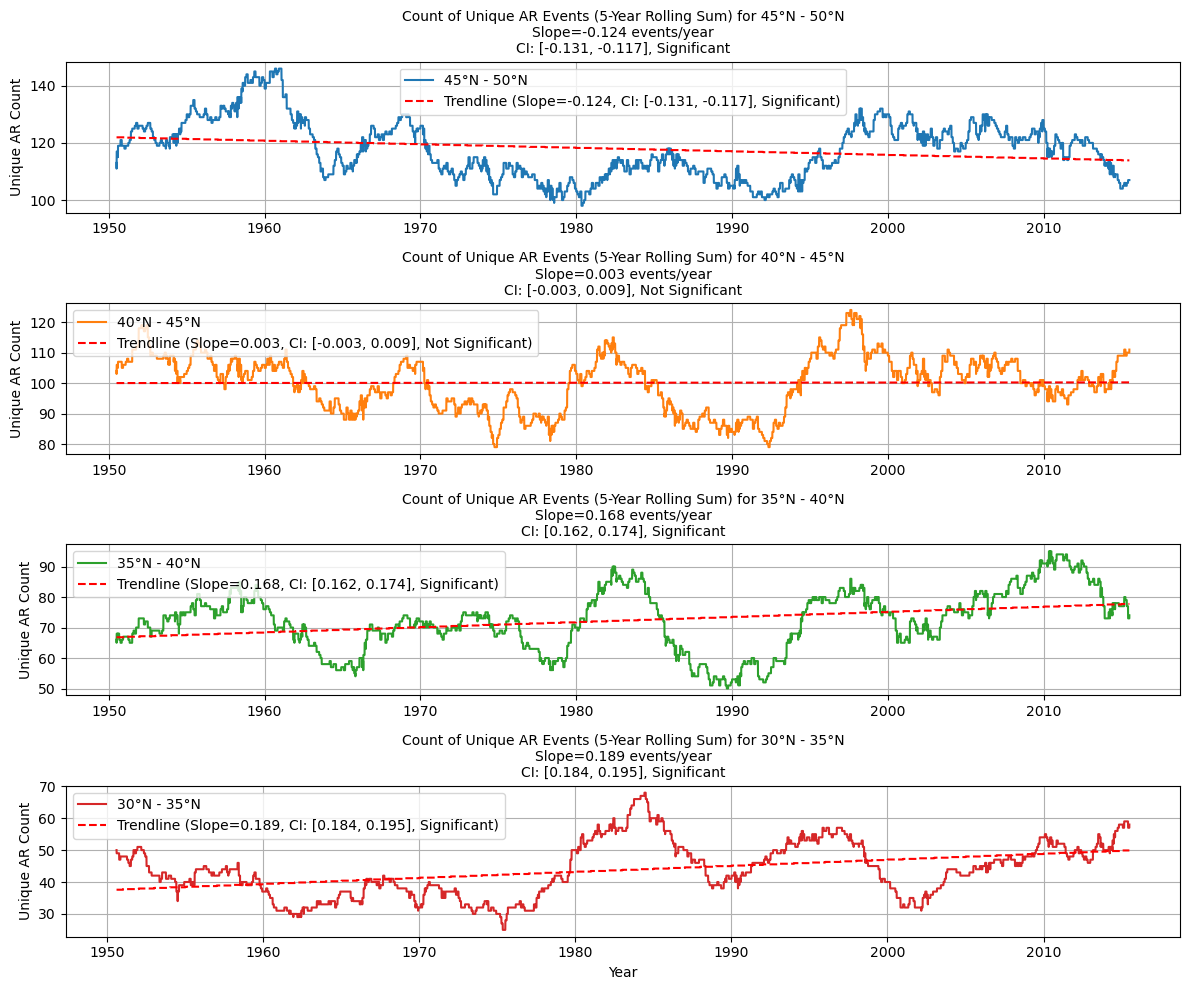

In [ ]:


# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
latitude = ar_catalog['Coastal_latitude'].values
ar_id = ar_catalog['AR_ID'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]
band_data = []

# Group data into latitude bands and calculate rolling unique AR_ID counts
for band in latitude_bands:
    # Mask for the current latitude band
    mask = (latitude >= band[0]) & (latitude < band[1])
    
    # Extract data for the latitude band
    band_time = time[mask]
    band_ar_id = ar_id[mask]
    
    # Create a DataFrame for grouping by day
    band_df = pd.DataFrame({'time': band_time, 'AR_ID': band_ar_id}).drop_duplicates()
    band_df.set_index('time', inplace=True)
    
    # Resample to daily frequency and count unique AR_IDs
    daily_unique_counts = band_df.resample('D').AR_ID.nunique()
    
    # Calculate the rolling sum of unique counts
    rolling_unique_counts = daily_unique_counts.rolling(window=window_size, center=True).sum()
    
    # Store data for plotting
    band_data.append((band, rolling_unique_counts.index, rolling_unique_counts.values))

# Plot the unique count of ARs for each latitude band with trendlines (reversed order)
plt.figure(figsize=(12, 10))

# Reverse the order of latitude bands for plotting
for i, (band, band_time, band_count) in enumerate(reversed(band_data)): 
    # Remove NaN values for regression
    valid_idx = ~pd.isnull(band_count)
    band_time_numeric = pd.to_datetime(band_time[valid_idx]).year  # Convert time to numeric for regression
    band_count_valid = band_count[valid_idx]
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(band_time_numeric, band_count_valid)
    
    # Calculate the 95% Confidence Interval for the slope
    n = len(band_count_valid)  # number of valid points
    t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
    margin_of_error = t_critical * std_err  # Margin of error for the slope
    ci_lower = slope - margin_of_error
    ci_upper = slope + margin_of_error
    significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
    
    # Plot the rolling count
    plt.subplot(len(latitude_bands), 1, i + 1)
    plt.plot(band_time, band_count, label=f"{band[0]}°N - {band[1]}°N", color=f"C{i}")
    
    # Plot the trendline
    trendline = slope * band_time_numeric + intercept
    plt.plot(band_time[valid_idx], trendline, color='red', linestyle='--', label=f'Trendline (Slope={slope:.3f}, CI: [{ci_lower:.3f}, {ci_upper:.3f}], {"Significant" if significant else "Not Significant"})')
    
    # Add title with slope value and CI info
    plt.title(f"Count of Unique AR Events (5-Year Rolling Sum) for {band[0]}°N - {band[1]}°N\nSlope={slope:.3f} events/year\nCI: [{ci_lower:.3f}, {ci_upper:.3f}], {'Significant' if significant else 'Not Significant'}", fontsize=10)
    plt.ylabel("Unique AR Count")
    plt.grid()
    plt.legend()

plt.xlabel("Year")
plt.tight_layout()
plt.show()


In [7]:

# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
latitude = ar_catalog['Coastal_latitude'].values
ar_id = ar_catalog['AR_ID'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]

# Create a dictionary to store results
results = {}

# Group data into latitude bands and calculate rolling unique AR_ID counts
for band in latitude_bands:
    # Mask for the current latitude band
    mask = (latitude >= band[0]) & (latitude < band[1])
    
    # Extract data for the latitude band
    band_time = time[mask]
    band_ar_id = ar_id[mask]
    
    # Create a DataFrame for grouping by day
    band_df = pd.DataFrame({'time': band_time, 'AR_ID': band_ar_id}).drop_duplicates()
    band_df.set_index('time', inplace=True)
    
    # Resample to daily frequency and count unique AR_IDs
    daily_unique_counts = band_df.resample('D').AR_ID.nunique()
    
    # Calculate the rolling sum of unique counts
    rolling_unique_counts = daily_unique_counts.rolling(window=window_size, center=True).sum()
    
    # Remove NaN values for regression
    valid_idx = ~pd.isnull(rolling_unique_counts.values)
    band_time_numeric = pd.to_datetime(rolling_unique_counts.index[valid_idx]).year  # Convert time to numeric for regression
    band_count_valid = rolling_unique_counts.values[valid_idx]
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(band_time_numeric, band_count_valid)
    
    # Calculate the 95% Confidence Interval for the slope
    n = len(band_count_valid)  # number of valid points
    t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
    margin_of_error = t_critical * std_err  # Margin of error for the slope
    ci_lower = slope - margin_of_error
    ci_upper = slope + margin_of_error
    significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
    
    # Store results in the dictionary
    results[f"{band[0]}°N-{band[1]}°N"] = {
        "Slope": slope,
        "CI_Lower": ci_lower,
        "CI_Upper": ci_upper,
        "Significant": significant
    }

# Print results
for band, metrics in results.items():
    print(f"Latitude Band: {band}")
    print(f"  Slope: {metrics['Slope']:.3f}")
    print(f"  95% CI: [{metrics['CI_Lower']:.3f}, {metrics['CI_Upper']:.3f}]")
    print(f"  Significant: {'Yes' if metrics['Significant'] else 'No'}")
    print("-" * 50)


Latitude Band: 30°N-35°N
  Slope: 0.189
  95% CI: [0.184, 0.195]
  Significant: Yes
--------------------------------------------------
Latitude Band: 35°N-40°N
  Slope: 0.168
  95% CI: [0.162, 0.174]
  Significant: Yes
--------------------------------------------------
Latitude Band: 40°N-45°N
  Slope: 0.003
  95% CI: [-0.003, 0.009]
  Significant: No
--------------------------------------------------
Latitude Band: 45°N-50°N
  Slope: -0.124
  95% CI: [-0.131, -0.117]
  Significant: Yes
--------------------------------------------------


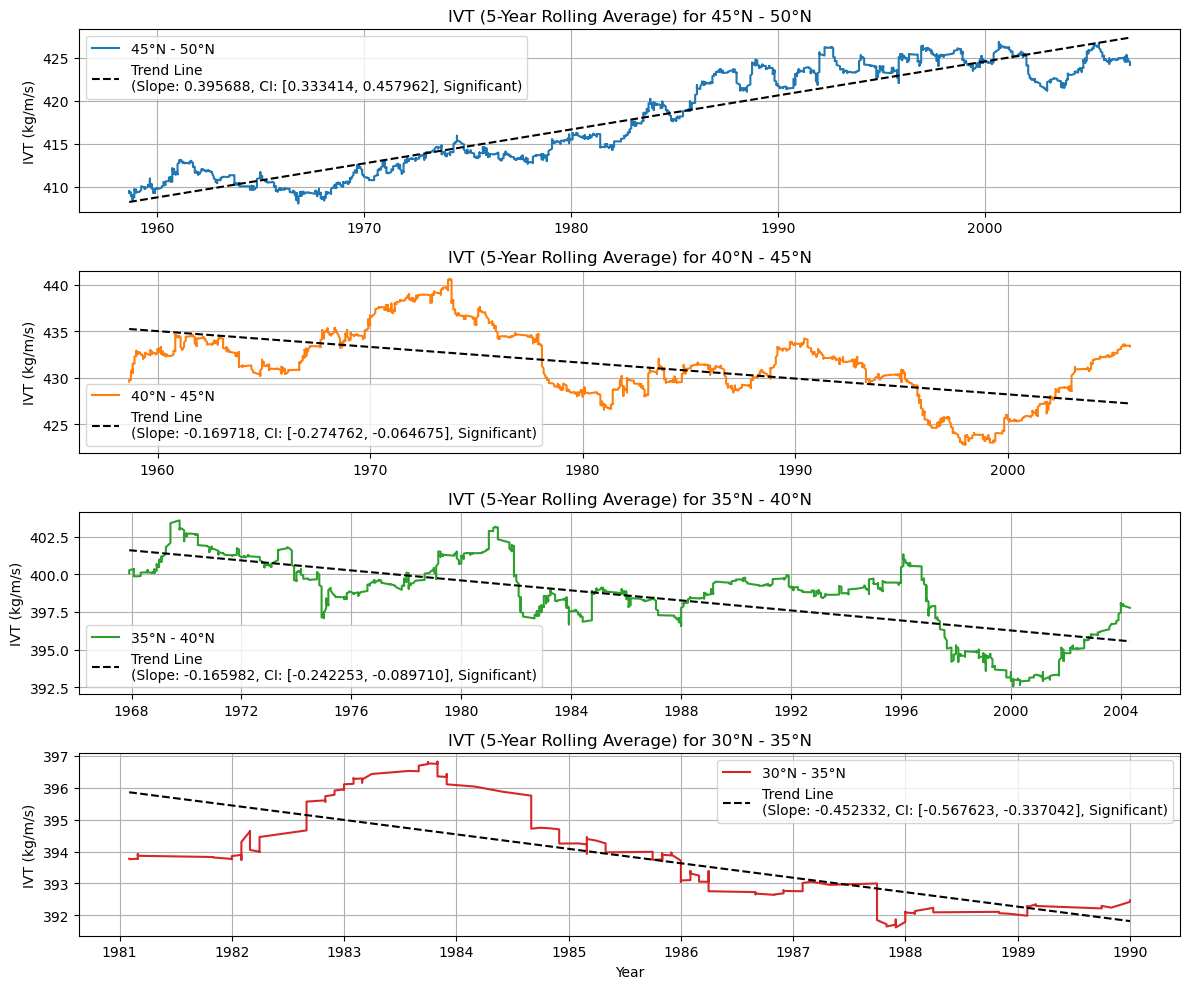

In [17]:
# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
latitude = ar_catalog['Coastal_latitude'].values
ivt = ar_catalog['IVT'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]
band_data = []

# Group data into latitude bands
for band in latitude_bands:
    mask = (latitude >= band[0]) & (latitude < band[1])
    band_ivt = pd.Series(ivt[mask]).rolling(window=window_size, center=True).mean()
    band_time = time[mask]
    band_data.append((band, band_time, band_ivt))

# Plot the IVT for each latitude band (in reversed order)
plt.figure(figsize=(12, 10))

# Reverse the order of latitude bands for plotting
for i, (band, band_time, band_ivt) in enumerate(reversed(band_data)):
    plt.subplot(len(latitude_bands), 1, i + 1)
    plt.plot(band_time, band_ivt, label=f"{band[0]}°N - {band[1]}°N", color=f"C{i}")
    
    # Add trendline with confidence interval
    valid_mask = ~np.isnan(band_ivt)
    if valid_mask.any():
        x_valid = pd.to_numeric(band_time[valid_mask]) / 10**9 / (60 * 60 * 24 * 365.25)  # Convert time to years
        y_valid = band_ivt[valid_mask]
        
        # Perform linear regression
        slope, intercept = np.polyfit(x_valid, y_valid, 1)
        residuals = y_valid - (slope * x_valid + intercept)  # Calculate residuals
        std_err = np.std(residuals) / np.sqrt(len(x_valid))  # Standard error of the slope
        
        # Calculate the 95% confidence interval for the slope
        n = len(x_valid)  # number of valid data points
        t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
        margin_of_error = t_critical * std_err  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
        
        # Plot the trendline
        plt.plot(
            band_time[valid_mask],
            slope * x_valid + intercept,
            color="black",
            linestyle="--",
            label=f"Trend Line\n(Slope: {slope:.6f}, CI: [{ci_lower:.6f}, {ci_upper:.6f}], {'Significant' if significant else 'Not Significant'})",
        )
    
    plt.title(f"IVT (5-Year Rolling Average) for {band[0]}°N - {band[1]}°N")
    plt.ylabel("IVT (kg/m/s)")
    plt.grid()
    plt.legend()

plt.xlabel("Year")
plt.tight_layout()
plt.show()


In [9]:

# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
latitude = ar_catalog['Coastal_latitude'].values
ivt = ar_catalog['IVT'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]

# Create a dictionary to store results
results = {}
band_data = []

# Group data into latitude bands and calculate rolling IVT
for band in latitude_bands:
    # Mask for the current latitude band
    mask = (latitude >= band[0]) & (latitude < band[1])
    
    # Extract time and IVT for the latitude band
    band_time = time[mask]
    band_ivt = pd.Series(ivt[mask]).rolling(window=window_size, center=True).mean()
    band_data.append((band, band_time, band_ivt))
    
    # Remove NaN values for regression
    valid_idx = ~pd.isnull(band_ivt.values)
    band_time_numeric = pd.to_datetime(band_time[valid_idx]).year  # Convert time to numeric for regression
    band_ivt_valid = band_ivt.values[valid_idx]
    
    if len(band_time_numeric) > 2:  # Ensure sufficient data points for regression
        # Perform linear regression
        slope, intercept = np.polyfit(band_time_numeric, band_ivt_valid, 1)
        residuals = band_ivt_valid - (slope * band_time_numeric + intercept)
        std_err = np.std(residuals) / np.sqrt(len(band_time_numeric))
        
        # Calculate the 95% Confidence Interval for the slope
        n = len(band_time_numeric)
        t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
        margin_of_error = t_critical * std_err  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
        
        # Store results in the dictionary
        results[f"{band[0]}°N-{band[1]}°N"] = {
            "Slope": slope,
            "CI_Lower": ci_lower,
            "CI_Upper": ci_upper,
            "Significant": significant
        }

# Print results
print("Results for IVT Trends by Latitude Band")
print("=" * 50)
for band, metrics in results.items():
    print(f"Latitude Band: {band}")
    print(f"  Slope: {metrics['Slope']:.3f}")
    print(f"  95% CI: [{metrics['CI_Lower']:.3f}, {metrics['CI_Upper']:.3f}]")
    print(f"  Significant: {'Yes' if metrics['Significant'] else 'No'}")
    print("-" * 50)



Results for IVT Trends by Latitude Band
Latitude Band: 30°N-35°N
  Slope: -0.472
  95% CI: [-0.582, -0.362]
  Significant: Yes
--------------------------------------------------
Latitude Band: 35°N-40°N
  Slope: -0.166
  95% CI: [-0.242, -0.089]
  Significant: Yes
--------------------------------------------------
Latitude Band: 40°N-45°N
  Slope: -0.169
  95% CI: [-0.274, -0.064]
  Significant: Yes
--------------------------------------------------
Latitude Band: 45°N-50°N
  Slope: 0.396
  95% CI: [0.333, 0.458]
  Significant: Yes
--------------------------------------------------


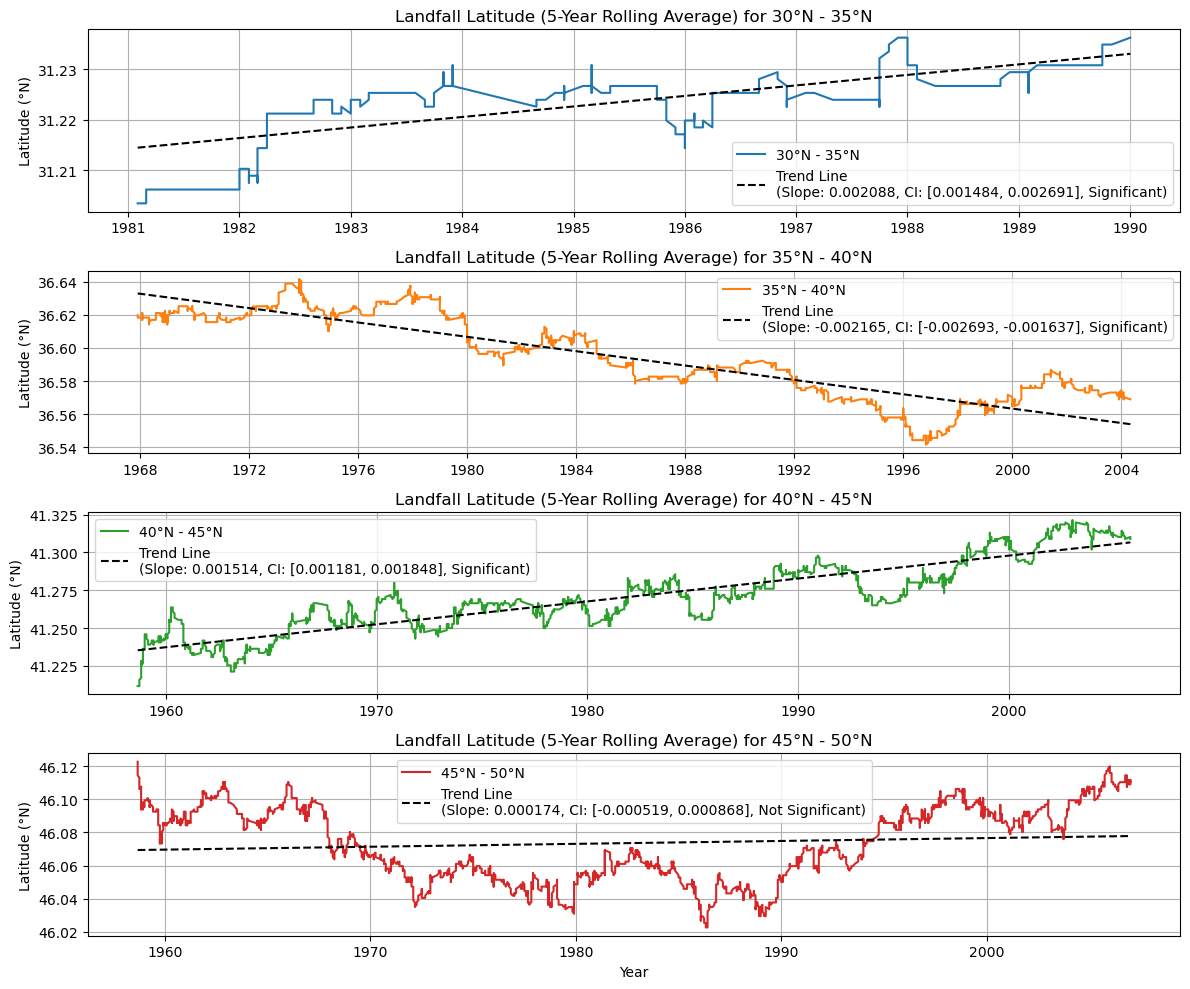

In [10]:

# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
latitude = ar_catalog['Coastal_latitude'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]
band_data = []

# Group data into latitude bands
for band in latitude_bands:
    mask = (latitude >= band[0]) & (latitude < band[1])
    band_latitude = pd.Series(latitude[mask]).rolling(window=window_size, center=True).mean()
    band_time = time[mask]
    band_data.append((band, band_time, band_latitude))

# Plot the landfall latitude for each latitude band
plt.figure(figsize=(12, 10))

for i, (band, band_time, band_latitude) in enumerate(band_data):
    plt.subplot(len(latitude_bands), 1, i + 1)
    plt.plot(band_time, band_latitude, label=f"{band[0]}°N - {band[1]}°N", color=f"C{i}")
    
    # Add trendline with confidence interval
    valid_mask = ~np.isnan(band_latitude)
    if valid_mask.any():
        x_valid = pd.to_numeric(band_time[valid_mask]) / 10**9 / (60 * 60 * 24 * 365.25)  # Convert time to years
        y_valid = band_latitude[valid_mask]
        
        # Perform linear regression
        slope, intercept = np.polyfit(x_valid, y_valid, 1)
        residuals = y_valid - (slope * x_valid + intercept)  # Calculate residuals
        std_err = np.std(residuals) / np.sqrt(len(x_valid))  # Standard error of the slope
        
        # Calculate the 95% confidence interval for the slope
        n = len(x_valid)  # number of valid data points
        t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
        margin_of_error = t_critical * std_err  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
        
        # Plot the trendline
        plt.plot(
            band_time[valid_mask],
            slope * x_valid + intercept,
            color="black",
            linestyle="--",
            label=f"Trend Line\n(Slope: {slope:.6f}, CI: [{ci_lower:.6f}, {ci_upper:.6f}], {'Significant' if significant else 'Not Significant'})",
        )
    
    plt.title(f"Landfall Latitude (5-Year Rolling Average) for {band[0]}°N - {band[1]}°N")
    plt.ylabel("Latitude (°N)")
    plt.grid()
    plt.legend()

plt.xlabel("Year")
plt.tight_layout()
plt.show()


In [11]:

# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
latitude = ar_catalog['Coastal_latitude'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]

# Create a dictionary to store results
results = {}
band_data = []

# Group data into latitude bands and calculate rolling latitude averages
for band in latitude_bands:
    # Mask for the current latitude band
    mask = (latitude >= band[0]) & (latitude < band[1])
    
    # Extract time and latitude for the latitude band
    band_time = time[mask]
    band_latitude = pd.Series(latitude[mask]).rolling(window=window_size, center=True).mean()
    band_data.append((band, band_time, band_latitude))
    
    # Remove NaN values for regression
    valid_idx = ~pd.isnull(band_latitude.values)
    band_time_numeric = pd.to_datetime(band_time[valid_idx]).year  # Convert time to numeric for regression
    band_latitude_valid = band_latitude.values[valid_idx]
    
    if len(band_time_numeric) > 2:  # Ensure sufficient data points for regression
        # Perform linear regression
        slope, intercept = np.polyfit(band_time_numeric, band_latitude_valid, 1)
        residuals = band_latitude_valid - (slope * band_time_numeric + intercept)
        std_err = np.std(residuals) / np.sqrt(len(band_time_numeric))
        
        # Calculate the 95% Confidence Interval for the slope
        n = len(band_time_numeric)
        t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
        margin_of_error = t_critical * std_err  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
        
        # Store results in the dictionary
        results[f"{band[0]}°N-{band[1]}°N"] = {
            "Slope": slope,
            "CI_Lower": ci_lower,
            "CI_Upper": ci_upper,
            "Significant": significant
        }

# Print results
print("Results for Landfall Latitude Trends by Latitude Band")
print("=" * 50)
for band, metrics in results.items():
    print(f"Latitude Band: {band}")
    print(f"  Slope: {metrics['Slope']:.3f}")
    print(f"  95% CI: [{metrics['CI_Lower']:.3f}, {metrics['CI_Upper']:.3f}]")
    print(f"  Significant: {'Yes' if metrics['Significant'] else 'No'}")
    print("-" * 50)


Results for Landfall Latitude Trends by Latitude Band
Latitude Band: 30°N-35°N
  Slope: 0.002
  95% CI: [0.001, 0.003]
  Significant: Yes
--------------------------------------------------
Latitude Band: 35°N-40°N
  Slope: -0.002
  95% CI: [-0.003, -0.002]
  Significant: Yes
--------------------------------------------------
Latitude Band: 40°N-45°N
  Slope: 0.002
  95% CI: [0.001, 0.002]
  Significant: Yes
--------------------------------------------------
Latitude Band: 45°N-50°N
  Slope: 0.000
  95% CI: [-0.001, 0.001]
  Significant: No
--------------------------------------------------


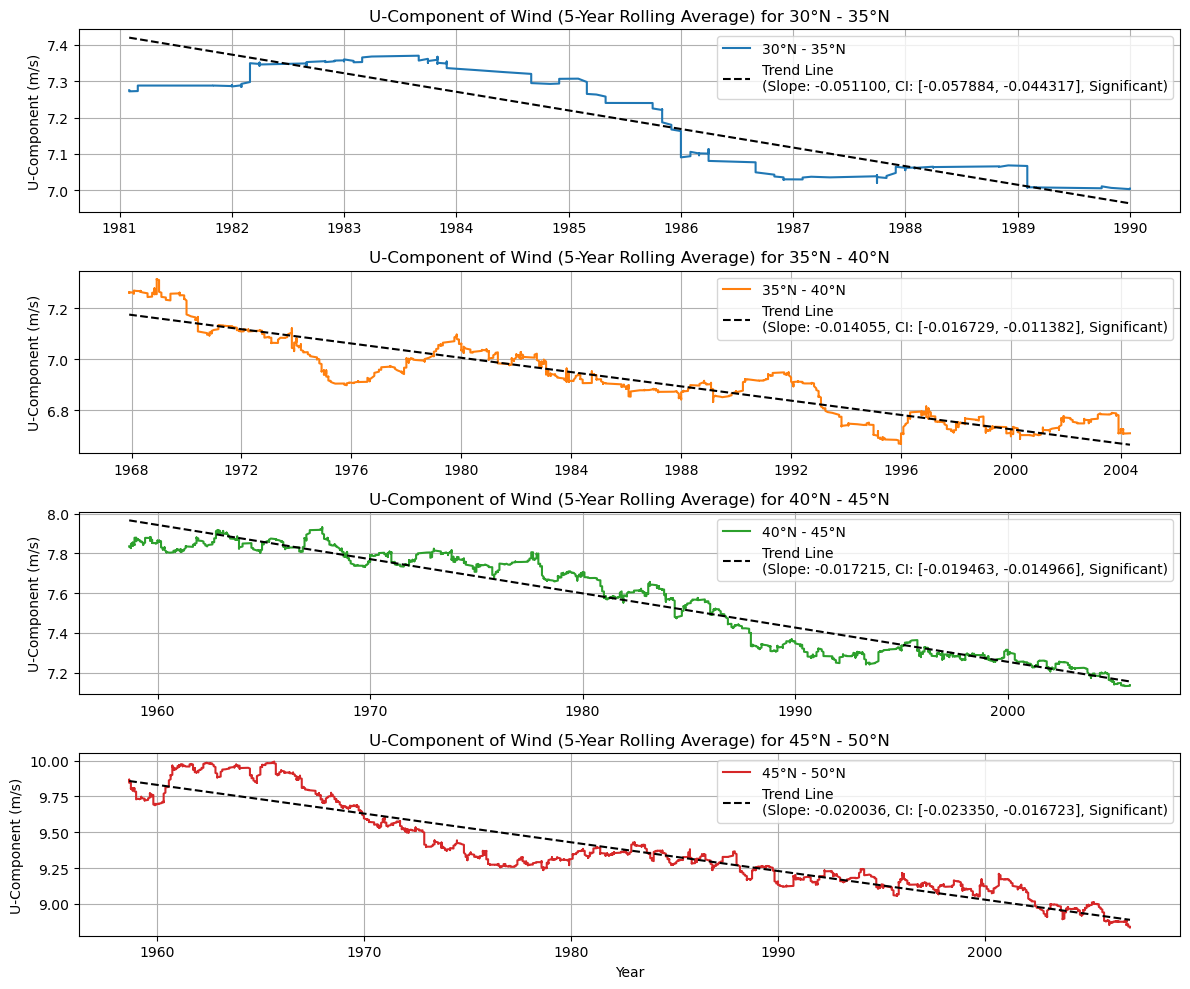

In [12]:

# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
u_component = ar_catalog['U_component'].values
latitude = ar_catalog['Coastal_latitude'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]
band_data = []

# Group data into latitude bands
for band in latitude_bands:
    mask = (latitude >= band[0]) & (latitude < band[1])
    band_u_component = pd.Series(u_component[mask]).rolling(window=window_size, center=True).mean()
    band_time = time[mask]
    band_data.append((band, band_time, band_u_component))

# Plot the U-Component of Wind for each latitude band
plt.figure(figsize=(12, 10))

for i, (band, band_time, band_u_component) in enumerate(band_data):
    plt.subplot(len(latitude_bands), 1, i + 1)
    plt.plot(band_time, band_u_component, label=f"{band[0]}°N - {band[1]}°N", color=f"C{i}")
    
    # Add trendline with confidence interval
    valid_mask = ~np.isnan(band_u_component)
    if valid_mask.any():
        x_valid = pd.to_numeric(band_time[valid_mask]) / 10**9 / (60 * 60 * 24 * 365.25)  # Convert time to years
        y_valid = band_u_component[valid_mask]
        
        # Perform linear regression
        slope, intercept = np.polyfit(x_valid, y_valid, 1)
        residuals = y_valid - (slope * x_valid + intercept)  # Calculate residuals
        std_err = np.std(residuals) / np.sqrt(len(x_valid))  # Standard error of the slope
        
        # Calculate the 95% confidence interval for the slope
        n = len(x_valid)  # number of valid data points
        t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
        margin_of_error = t_critical * std_err  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
        
        # Plot the trendline
        plt.plot(
            band_time[valid_mask],
            slope * x_valid + intercept,
            color="black",
            linestyle="--",
            label=f"Trend Line\n(Slope: {slope:.6f}, CI: [{ci_lower:.6f}, {ci_upper:.6f}], {'Significant' if significant else 'Not Significant'})",
        )
    
    plt.title(f"U-Component of Wind (5-Year Rolling Average) for {band[0]}°N - {band[1]}°N")
    plt.ylabel("U-Component (m/s)")
    plt.grid()
    plt.legend()

plt.xlabel("Year")
plt.tight_layout()
plt.show()


In [13]:

# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
u_component = ar_catalog['U_component'].values
latitude = ar_catalog['Coastal_latitude'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]

# Create a dictionary to store results
results = {}

# Group data into latitude bands and calculate rolling latitude averages for U-component
for band in latitude_bands:
    # Mask for the current latitude band
    mask = (latitude >= band[0]) & (latitude < band[1])
    
    # Extract time and U-component for the latitude band
    band_time = time[mask]
    band_u_component = pd.Series(u_component[mask]).rolling(window=window_size, center=True).mean()

    # Remove NaN values for regression
    valid_idx = ~pd.isnull(band_u_component.values)
    band_time_numeric = pd.to_datetime(band_time[valid_idx]).year  # Convert time to numeric for regression
    band_u_component_valid = band_u_component.values[valid_idx]
    
    if len(band_time_numeric) > 2:  # Ensure sufficient data points for regression
        # Perform linear regression
        slope, intercept = np.polyfit(band_time_numeric, band_u_component_valid, 1)
        residuals = band_u_component_valid - (slope * band_time_numeric + intercept)
        std_err = np.std(residuals) / np.sqrt(len(band_time_numeric))
        
        # Calculate the 95% Confidence Interval for the slope
        n = len(band_time_numeric)
        t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
        margin_of_error = t_critical * std_err  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
        
        # Store results in the dictionary
        results[f"{band[0]}°N-{band[1]}°N"] = {
            "Slope": slope,
            "CI_Lower": ci_lower,
            "CI_Upper": ci_upper,
            "Significant": significant
        }

# Print results
print("Results for U-Component of Wind by Latitude Band")
print("=" * 50)
for band, metrics in results.items():
    print(f"Latitude Band: {band}")
    print(f"  Slope: {metrics['Slope']:.3f}")
    print(f"  95% CI: [{metrics['CI_Lower']:.3f}, {metrics['CI_Upper']:.3f}]")
    print(f"  Significant: {'Yes' if metrics['Significant'] else 'No'}")
    print("-" * 50)


Results for U-Component of Wind by Latitude Band
Latitude Band: 30°N-35°N
  Slope: -0.052
  95% CI: [-0.058, -0.045]
  Significant: Yes
--------------------------------------------------
Latitude Band: 35°N-40°N
  Slope: -0.014
  95% CI: [-0.017, -0.011]
  Significant: Yes
--------------------------------------------------
Latitude Band: 40°N-45°N
  Slope: -0.017
  95% CI: [-0.019, -0.015]
  Significant: Yes
--------------------------------------------------
Latitude Band: 45°N-50°N
  Slope: -0.020
  95% CI: [-0.023, -0.017]
  Significant: Yes
--------------------------------------------------


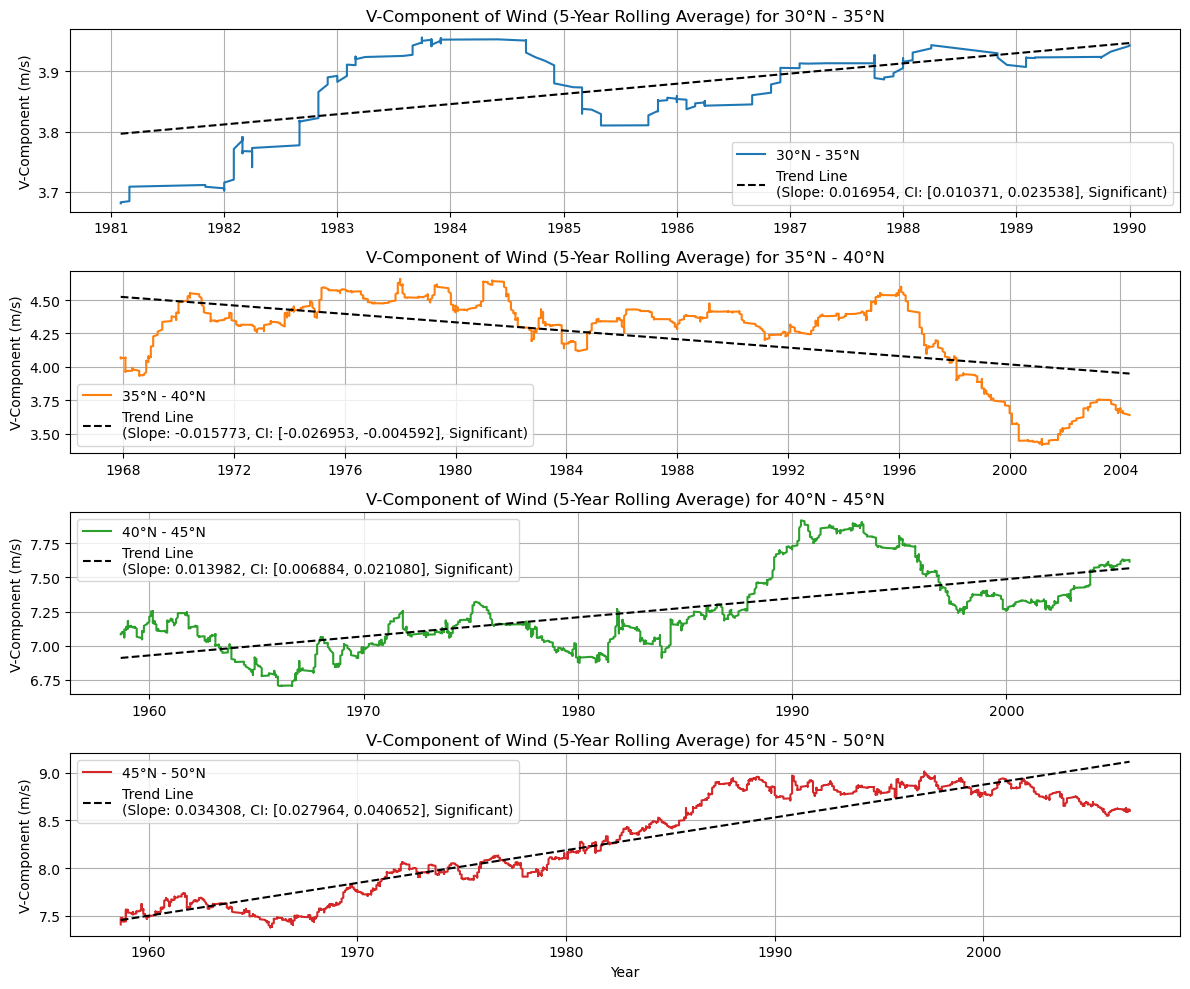

In [14]:


# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
v_component = ar_catalog['V_component'].values
latitude = ar_catalog['Coastal_latitude'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]
band_data = []

# Group data into latitude bands
for band in latitude_bands:
    mask = (latitude >= band[0]) & (latitude < band[1])
    band_v_component = pd.Series(v_component[mask]).rolling(window=window_size, center=True).mean()
    band_time = time[mask]
    band_data.append((band, band_time, band_v_component))

# Plot the V-Component of Wind for each latitude band
plt.figure(figsize=(12, 10))

for i, (band, band_time, band_v_component) in enumerate(band_data):
    plt.subplot(len(latitude_bands), 1, i + 1)
    plt.plot(band_time, band_v_component, label=f"{band[0]}°N - {band[1]}°N", color=f"C{i}")
    
    # Add trendline with confidence interval
    valid_mask = ~np.isnan(band_v_component)
    if valid_mask.any():
        x_valid = pd.to_numeric(band_time[valid_mask]) / 10**9 / (60 * 60 * 24 * 365.25)  # Convert time to years
        y_valid = band_v_component[valid_mask]
        
        # Perform linear regression
        slope, intercept = np.polyfit(x_valid, y_valid, 1)
        residuals = y_valid - (slope * x_valid + intercept)  # Calculate residuals
        std_err = np.std(residuals) / np.sqrt(len(x_valid))  # Standard error of the slope
        
        # Calculate the 95% confidence interval for the slope
        n = len(x_valid)  # number of valid data points
        t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
        margin_of_error = t_critical * std_err  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
        
        # Plot the trendline
        plt.plot(
            band_time[valid_mask],
            slope * x_valid + intercept,
            color="black",
            linestyle="--",
            label=f"Trend Line\n(Slope: {slope:.6f}, CI: [{ci_lower:.6f}, {ci_upper:.6f}], {'Significant' if significant else 'Not Significant'})",
        )
    
    plt.title(f"V-Component of Wind (5-Year Rolling Average) for {band[0]}°N - {band[1]}°N")
    plt.ylabel("V-Component (m/s)")
    plt.grid()
    plt.legend()

plt.xlabel("Year")
plt.tight_layout()
plt.show()


In [15]:


# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
v_component = ar_catalog['V_component'].values  # Use V-component instead of U-component
latitude = ar_catalog['Coastal_latitude'].values

# Define a 5-year rolling window size (1826 days)
window_size = 1826

# Define latitude bands
latitude_bands = [(30, 35), (35, 40), (40, 45), (45, 50)]

# Create a dictionary to store results
results = {}

# Group data into latitude bands and calculate rolling latitude averages for V-component
for band in latitude_bands:
    # Mask for the current latitude band
    mask = (latitude >= band[0]) & (latitude < band[1])
    
    # Extract time and V-component for the latitude band
    band_time = time[mask]
    band_v_component = pd.Series(v_component[mask]).rolling(window=window_size, center=True).mean()

    # Remove NaN values for regression
    valid_idx = ~pd.isnull(band_v_component.values)
    band_time_numeric = pd.to_datetime(band_time[valid_idx]).year  # Convert time to numeric for regression
    band_v_component_valid = band_v_component.values[valid_idx]
    
    if len(band_time_numeric) > 2:  # Ensure sufficient data points for regression
        # Perform linear regression
        slope, intercept = np.polyfit(band_time_numeric, band_v_component_valid, 1)
        residuals = band_v_component_valid - (slope * band_time_numeric + intercept)
        std_err = np.std(residuals) / np.sqrt(len(band_time_numeric))
        
        # Calculate the 95% Confidence Interval for the slope
        n = len(band_time_numeric)
        t_critical = t.ppf(1 - 0.025, df=n - 2)  # 95% confidence, two-tailed
        margin_of_error = t_critical * std_err  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        significant = ci_lower > 0 or ci_upper < 0  # Check if the confidence interval includes zero
        
        # Store results in the dictionary
        results[f"{band[0]}°N-{band[1]}°N"] = {
            "Slope": slope,
            "CI_Lower": ci_lower,
            "CI_Upper": ci_upper,
            "Significant": significant
        }

# Print results
print("Results for V-Component of Wind by Latitude Band")
print("=" * 50)
for band, metrics in results.items():
    print(f"Latitude Band: {band}")
    print(f"  Slope: {metrics['Slope']:.3f}")
    print(f"  95% CI: [{metrics['CI_Lower']:.3f}, {metrics['CI_Upper']:.3f}]")
    print(f"  Significant: {'Yes' if metrics['Significant'] else 'No'}")
    print("-" * 50)


Results for V-Component of Wind by Latitude Band
Latitude Band: 30°N-35°N
  Slope: 0.015
  95% CI: [0.008, 0.022]
  Significant: Yes
--------------------------------------------------
Latitude Band: 35°N-40°N
  Slope: -0.016
  95% CI: [-0.027, -0.004]
  Significant: Yes
--------------------------------------------------
Latitude Band: 40°N-45°N
  Slope: 0.014
  95% CI: [0.007, 0.021]
  Significant: Yes
--------------------------------------------------
Latitude Band: 45°N-50°N
  Slope: 0.034
  95% CI: [0.028, 0.041]
  Significant: Yes
--------------------------------------------------


## Atmospheric River Category Trends

In [16]:
for i, category in enumerate(ivt_categories):
    mask = (ivt >= category[0]) & (ivt < category[1])
    print(f"Category {i + 1}: {category[0]}-{category[1]} IVT -> {np.sum(mask)} data points")


NameError: name 'ivt_categories' is not defined

In [23]:
mask = (ivt >= 750) & (ivt < 1000)  # Category 3 example
rolling_ivt = pd.Series(ivt[mask]).rolling(window=window_size, center=True).mean()
print("Rolling IVT for Category 3:", rolling_ivt[:10])


Rolling IVT for Category 3: 0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
dtype: float64


C:\Users\brand\AppData\Local\Temp\ipykernel_9764\1337758286.py:60: RuntimeWarning: divide by zero encountered in scalar divide
  standard_error = np.sqrt(residual_sum_of_squares / degrees_of_freedom) / np.sqrt(np.sum((x_valid - np.mean(x_valid))**2))


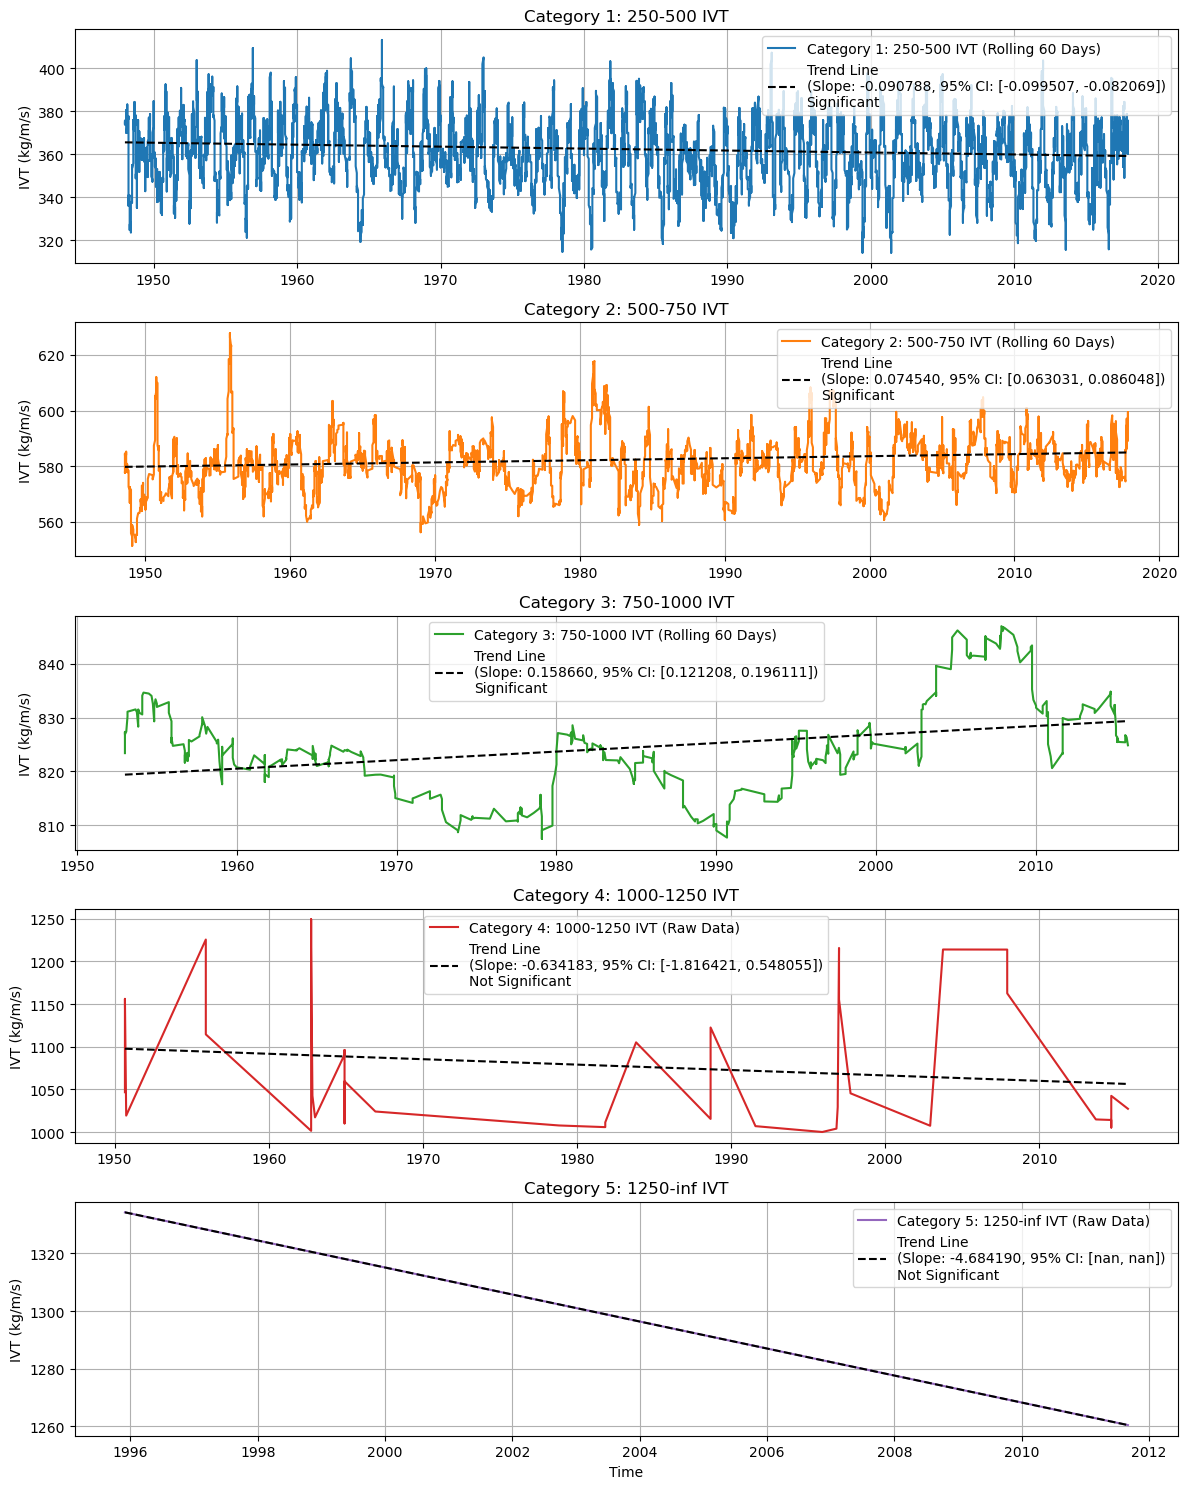

2024-12-11 21:46:59,512 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:58093', name: 0, status: running, memory: 0, processing: 0>
2024-12-11 21:46:59,580 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:58097', name: 2, status: running, memory: 0, processing: 0>
2024-12-11 21:46:59,593 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:58093'.
2024-12-11 21:46:59,614 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:58097'.
2024-12-11 21:47:20,436 - distributed.nanny - WARNING - Worker process still alive after 3.199972534179688 seconds, killing
2024-12-11 21:47:20,441 - distributed.nanny - WARNING - Worker process still alive after 3.1999958801269535 seconds, killing


In [ ]:


# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
ivt = ar_catalog['IVT'].values

# Define IVT categories
ivt_categories = [
    (250, 500),    # Category 1
    (500, 750),    # Category 2
    (750, 1000),   # Category 3
    (1000, 1250),  # Category 4
    (1250, np.inf) # Category 5
]

# Define the rolling window size for the first 3 categories (60 days)
rolling_window = 60

plt.figure(figsize=(12, 15))

# Loop over each IVT category and plot the time series with rolling window for categories 1-3
for i, category in enumerate(ivt_categories):
    mask = (ivt >= category[0]) & (ivt < category[1])
    category_time = time[mask]
    category_ivt = ivt[mask]

    # Skip plotting if no data exists for the category
    if np.sum(mask) == 0:
        print(f"No data for Category {i + 1}: {category[0]}-{category[1]} IVT")
        continue
    
    # Apply rolling window only to the first 3 categories
    if i < 3:  # Apply 60-day rolling for Category 1, 2, and 3
        category_ivt = pd.Series(category_ivt).rolling(window=rolling_window, center=True).mean()
        label_suffix = f"(Rolling {rolling_window} Days)"
    else:
        label_suffix = "(Raw Data)"  # No rolling for Categories 4 and 5
    
    # Plot the smoothed or raw data
    plt.subplot(len(ivt_categories), 1, i + 1)
    plt.plot(category_time, category_ivt, label=f"Category {i + 1}: {category[0]}-{category[1]} IVT {label_suffix}", color=f"C{i}")
    
    # Calculate and plot trendline with confidence interval
    valid_mask = ~np.isnan(category_ivt)
    if valid_mask.any():
        x_valid = pd.to_numeric(category_time[valid_mask]) / 10**9 / (60 * 60 * 24 * 365.25)  # Convert time to years
        y_valid = category_ivt[valid_mask]
        
        # Fit the trendline (linear regression)
        slope, intercept = np.polyfit(x_valid, y_valid, 1)

        # Calculate residuals and standard error of the slope
        y_pred = slope * x_valid + intercept
        residuals = y_valid - y_pred
        residual_sum_of_squares = np.sum(residuals**2)
        degrees_of_freedom = len(x_valid) - 2
        standard_error = np.sqrt(residual_sum_of_squares / degrees_of_freedom) / np.sqrt(np.sum((x_valid - np.mean(x_valid))**2))
        
        # Calculate the t-statistic and p-value
        t_stat = slope / standard_error
        p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), degrees_of_freedom))  # Two-tailed test
        
        # Calculate the 95% confidence interval for the slope
        t_critical = stats.t.ppf(1 - 0.025, df=degrees_of_freedom)  # 95% confidence, two-tailed
        margin_of_error = t_critical * standard_error  # Margin of error for the slope
        ci_lower = slope - margin_of_error
        ci_upper = slope + margin_of_error
        
        # Determine if trend is significant
        if p_value < 0.05:
            significance_label = "Significant"
        else:
            significance_label = "Not Significant"
        
        # Plot the trendline
        plt.plot(
            category_time[valid_mask],
            slope * x_valid + intercept,
            color="black",
            linestyle="--",
            label=f"Trend Line\n(Slope: {slope:.6f}, 95% CI: [{ci_lower:.6f}, {ci_upper:.6f}])\n{significance_label}"
        )

    # Adding the title, grid, and legend
    plt.title(f"Category {i + 1}: {category[0]}-{category[1]} IVT")
    plt.ylabel("IVT (kg/m/s)")
    plt.grid()
    plt.legend()

plt.xlabel("Time")
plt.tight_layout()
plt.show()






In [ ]:

# Extract variables
time = pd.to_datetime(ar_catalog['time'].values)
ivt = ar_catalog['IVT'].values

# Define IVT categories
ivt_categories = [
    (250, 500),    # Category 1
    (500, 750),    # Category 2
    (750, 1000),   # Category 3
    (1000, 1250),  # Category 4
    (1250, np.inf) # Category 5
]

# Define the rolling window size for the first 3 categories (60 days)
rolling_window = 60

# Create a dictionary to store results
results = {}

# Loop over each IVT category
for i, category in enumerate(ivt_categories):
    # Mask to filter data within the category
    mask = (ivt >= category[0]) & (ivt < category[1])
    category_time = time[mask]
    category_ivt = ivt[mask]

    # Apply rolling mean for the first 3 categories
    if i < 3:
        category_ivt = pd.Series(category_ivt).rolling(window=rolling_window, center=True).mean().to_numpy()
    
    # Remove NaN values for regression
    valid_mask = ~np.isnan(category_ivt)
    if valid_mask.sum() == 0:  # Skip if no valid data points
        print(f"No data available for Category {i + 1}: {category[0]}-{category[1]} IVT")
        continue
    
    category_time_valid = category_time[valid_mask]
    category_ivt_valid = category_ivt[valid_mask]  # Already a numpy array
    category_time_numeric = pd.to_numeric(category_time_valid) / 10**9 / (60 * 60 * 24 * 365.25)  # Convert time to years

    # Perform linear regression
    slope, intercept = np.polyfit(category_time_numeric, category_ivt_valid, 1)
    y_pred = slope * category_time_numeric + intercept

    # Calculate residuals and standard error
    residuals = category_ivt_valid - y_pred
    residual_sum_of_squares = np.sum(residuals**2)
    degrees_of_freedom = len(category_time_numeric) - 2
    standard_error = np.sqrt(residual_sum_of_squares / degrees_of_freedom) / np.sqrt(np.sum((category_time_numeric - np.mean(category_time_numeric))**2))

    # Calculate the 95% confidence interval for the slope
    t_critical = t.ppf(1 - 0.025, df=degrees_of_freedom)
    margin_of_error = t_critical * standard_error
    ci_lower = slope - margin_of_error
    ci_upper = slope + margin_of_error

    # Check significance
    significant = ci_lower > 0 or ci_upper < 0

    # Store results in the dictionary
    results[f"Category {i + 1}: {category[0]}-{category[1]} IVT"] = {
        "Slope": slope,
        "CI_Lower": ci_lower,
        "CI_Upper": ci_upper,
        "Significant": significant
    }

# Print results
print("Results for IVT Categories")
print("=" * 50)
for category, metrics in results.items():
    print(f"{category}")
    print(f"  Slope: {metrics['Slope']:.6f}")
    print(f"  95% CI: [{metrics['CI_Lower']:.6f}, {metrics['CI_Upper']:.6f}]")
    print(f"  Significant: {'Yes' if metrics['Significant'] else 'No'}")
    print("-" * 50)


Results for IVT Categories
Category 1: 250-500 IVT
  Slope: -0.090788
  95% CI: [-0.099507, -0.082069]
  Significant: Yes
--------------------------------------------------
Category 2: 500-750 IVT
  Slope: 0.074540
  95% CI: [0.063031, 0.086048]
  Significant: Yes
--------------------------------------------------
Category 3: 750-1000 IVT
  Slope: 0.158660
  95% CI: [0.121208, 0.196111]
  Significant: Yes
--------------------------------------------------
Category 4: 1000-1250 IVT
  Slope: -0.634183
  95% CI: [-1.816421, 0.548055]
  Significant: No
--------------------------------------------------
Category 5: 1250-inf IVT
  Slope: -4.684190
  95% CI: [nan, nan]
  Significant: No
--------------------------------------------------


C:\Users\brand\AppData\Local\Temp\ipykernel_9764\2741189795.py:53: RuntimeWarning: divide by zero encountered in scalar divide
  standard_error = np.sqrt(residual_sum_of_squares / degrees_of_freedom) / np.sqrt(np.sum((category_time_numeric - np.mean(category_time_numeric))**2))
